In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
from spacy.lang.en import English
import spacy
spacy.prefer_gpu()
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Concatenate,GlobalMaxPool2D,Multiply
from tensorflow.keras.layers import Dropout, Subtract, Add, GlobalAvgPool2D, Conv2D, Bidirectional
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

In [2]:
print("Loading training file from path: ", config.config_io.get('pan_21_processed_train'))
training_data = pd.read_csv(config.config_io.get('pan_21_processed_train'))
training_data.head()

Loading training file from path:  /home/sukanya/PhD/Datasets/PAN SCD/pan21-style-change-detection/processed/train.csv


,problem,author_1,author_2,para1_text,para2_text
0,problem-4845.txt,1,2,I can't see the names (as you've properly reda...,Does it have anything to do that in this parti...
1,problem-4845.txt,2,2,Does it have anything to do that in this parti...,I am having a problem with connectivity in one...
2,problem-4845.txt,2,1,I am having a problem with connectivity in one...,Aliases are a way for the client to be redirec...
3,problem-4845.txt,1,1,Aliases are a way for the client to be redirec...,It doesn't deal with any of that. It specifica...
4,problem-9721.txt,1,2,"There is no non-root command, but a root comma...","For my situation, the use of locking is not su..."


In [3]:
training_data["is_diff_author"] = (training_data['author_1'] != training_data['author_2']).astype(int).to_numpy()

In [ ]:
.astype(str).values

In [57]:
training_data.head()

,problem,author_1,author_2,para1_text,para2_text,is_diff_author
0,problem-4845.txt,1,2,I can't see the names (as you've properly reda...,Does it have anything to do that in this parti...,1
1,problem-4845.txt,2,2,Does it have anything to do that in this parti...,I am having a problem with connectivity in one...,0
2,problem-4845.txt,2,1,I am having a problem with connectivity in one...,Aliases are a way for the client to be redirec...,1
3,problem-4845.txt,1,1,Aliases are a way for the client to be redirec...,It doesn't deal with any of that. It specifica...,0
4,problem-9721.txt,1,2,"There is no non-root command, but a root comma...","For my situation, the use of locking is not su...",1


In [4]:
# this portion will eventually be replaced by a proper data generator which will give batches
n = len(training_data)
x_train = training_data[0:int(n*0.1)][['para1_text', 'para2_text']]
x_val = training_data[int(n*0.1): int(n*0.15)][['para1_text', 'para2_text']]
y_train = training_data[0:int(n*0.1)][['is_diff_author']]
y_val = training_data[int(n*0.1): int(n*0.15):][['is_diff_author']]

In [5]:
y_val.shape

(3302, 1)

In [6]:
combined = x_train["para1_text"] + " " + x_train["para2_text"]

In [7]:
max_words = 10000
t = Tokenizer(num_words=max_words, oov_token="<OOV>")
t.fit_on_texts(combined.values)
sequences = tok.texts_to_sequences(combined)
sequences = pad_sequences(sequences, maxlen=300, padding='post')

In [8]:
train_p1_seq = t.texts_to_sequences(x_train['para1_text'].values)
train_p2_seq = t.texts_to_sequences(x_train['para2_text'].values)
val_p1_seq = t.texts_to_sequences(x_val['para1_text'].values)
val_p2_seq = t.texts_to_sequences(x_val['para2_text'].values)


In [9]:
len(train_p1_seq)

6605

In [10]:
vec_len = [len(sent_vec) for sent_vec in train_p1_seq] + [len(sent_vec) for sent_vec in train_p2_seq]
max_len = max(vec_len)

(array([9.033e+03, 3.494e+03, 5.390e+02, 1.010e+02, 2.800e+01, 1.100e+01,
        0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([  8. ,  49.6,  91.2, 132.8, 174.4, 216. , 257.6, 299.2, 340.8,
        382.4, 424. ]),
 <a list of 10 Patch objects>)

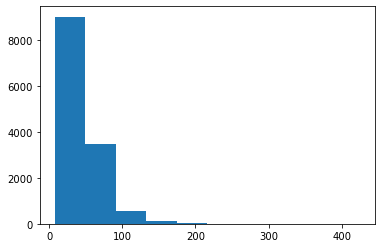

In [11]:
plt.hist(vec_len)

In [12]:
max_len

424

We see that most of the values are less than say len 100, so we can infact try with length 200 and see how that goes

In [13]:
max_len = 300
train_p1_seq = pad_sequences(train_p1_seq, maxlen=max_len, padding='post')
train_p2_seq = pad_sequences(train_p2_seq, maxlen=max_len, padding='post')
val_p1_seq = pad_sequences(val_p1_seq, maxlen=max_len, padding='post')
val_p2_seq = pad_sequences(val_p2_seq, maxlen=max_len, padding='post')


In [14]:
embeddings_index = {}
f = open('/home/sukanya/PhD/Embeddings/Glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
def get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = 50):
    """
    t: tokenizer
    
    """
    not_present_list = []
    vocab_size = len(t.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
    for word, i in t.word_index.items():
        embedding_vector = None
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index.get(word)
        else:
            not_present_list.append(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.zeros(embedding_vector_size) # size of the embedding
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embedding_matrix

In [18]:
embedding_dim = 50
embed_matrix = get_glove_embed_matrix(t, embeddings_index, embedding_vector_size = embedding_dim)

Loaded 400000 word vectors.


In [19]:
embed_matrix.shape

(15962, 50)

In [65]:
train_p1_seq.shape[1]

300

In [3]:
input_1 = Input(shape=(train_p1_seq.shape[1],))
input_2 = Input(shape=(train_p2_seq.shape[1],))


lstm_layer = Bidirectional(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
#tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))# loading our matrix
# max_words 10000 , embedding_dim = 50, max_len = 100
emb =  Embedding(15962, embedding_dim, input_length=max_len, weights=[embed_matrix],trainable=False)

e1 = emb(input1)
x1 = lstm_layer(e1)
e2 = emb(input2)
x2 = lstm_layer(e2)


mhd = lambda x: tf.keras.backend.abs(x[0] - x[1])


merged = tf.keras.layers.Lambda(function=mhd, output_shape=lambda x: x[0],
name='L1_distance')([x1, x2])
preds = tf.keras.layers.Dense(1, activation='sigmoid')(merged)
model = tf.keras.Model(inputs=[input1, input2], outputs=preds)
model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

NameError: name 'Input' is not defined

In [60]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 50)      798100      input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 20)           4880        embedding_6[0][0]          

In [62]:
model.fit([train_p1_seq,train_p2_seq],y_train.values.reshape(-1,1), epochs = 20,
          batch_size=64,validation_data=([val_p1_seq, val_p2_seq],y_val.values.reshape(-1,1)))

Epoch 1/5
104/104 [==============================] - 29s 236ms/step - loss: 0.6994 - acc: 0.4839 - val_loss: 0.7037 - val_acc: 0.4334
Epoch 2/5
104/104 [==============================] - 28s 272ms/step - loss: 0.7011 - acc: 0.4711 - val_loss: 0.7033 - val_acc: 0.4352
Epoch 3/5
104/104 [==============================] - 27s 261ms/step - loss: 0.6993 - acc: 0.4714 - val_loss: 0.7029 - val_acc: 0.4352
Epoch 4/5
104/104 [==============================] - 27s 262ms/step - loss: 0.6979 - acc: 0.4845 - val_loss: 0.7025 - val_acc: 0.4349
Epoch 5/5
104/104 [==============================] - 28s 269ms/step - loss: 0.7007 - acc: 0.4646 - val_loss: 0.7022 - val_acc: 0.4376


In [63]:
test_loss, test_acc = model.evaluate([val_p1_seq, val_p2_seq], y_val.values)

104/104 [==============================] - 4s 39ms/step - loss: 0.7022 - acc: 0.4376


In [64]:
test_acc

0.4376135766506195